In [1]:
import wandb
wandb.login(key="77d2ef98bdddf2be0b779711890e81fada9114f8")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import wandb
#from model import FlexibleCNN
import random
import numpy as np
from tqdm import tqdm

class iNaturalistDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        try:
            self.classes.remove(".DS_Store")
        except:
            pass
        #print(self.classes)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name == ".DS_Store":
                    continue
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

In [3]:
import torch
import torch.nn as nn

class FlexibleCNN(nn.Module):
    def __init__(self, 
                 num_classes=10,
                 conv_filters=[32, 32, 32, 32, 32],  # Number of filters for each conv layer
                 kernel_size=3,
                 activation='relu',
                 dense_neurons=64,
                 dropout_rate=0.0,
                 use_batch_norm=False):
        super(FlexibleCNN, self).__init__()
        
        # Activation function selection
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'silu':
            self.activation = nn.SiLU()
        elif activation.lower() == 'mish':
            self.activation = nn.Mish()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Convolutional layers
        self.conv_blocks = nn.ModuleList()
        in_channels = 3  # RGB input
        
        for num_filters in conv_filters:
            conv_block = []
            # Conv layer
            conv_block.append(nn.Conv2d(in_channels, num_filters, kernel_size, padding=kernel_size//2))
            
            # Batch normalization if requested
            if use_batch_norm:
                conv_block.append(nn.BatchNorm2d(num_filters))
            
            # Activation
            conv_block.append(self.activation)
            
            # Max pooling
            conv_block.append(nn.MaxPool2d(2))
            
            # Add dropout if rate > 0
            if dropout_rate > 0:
                conv_block.append(nn.Dropout2d(dropout_rate))
            
            self.conv_blocks.append(nn.Sequential(*conv_block))
            in_channels = num_filters
        
        # Calculate the size of flattened features
        self.flatten = nn.Flatten()
        
        # Dense layers
        self.dense = nn.Sequential(
            nn.Linear(in_channels * 8 * 8, dense_neurons),  # 8x8 due to 5 max pooling layers
            self.activation,
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(dense_neurons, num_classes)
        )
    
    def forward(self, x):
        # Apply convolutional blocks
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        
        # Flatten and apply dense layers
        x = self.flatten(x)
        x = self.dense(x)
        return x 

In [ ]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Set random seeds for reproducibility
        torch.manual_seed(config.seed)
        random.seed(config.seed)
        np.random.seed(config.seed)
        
        # Data transforms
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        val_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load dataset
        dataset = iNaturalistDataset(r"/kaggle/input/inaturalist12k/inaturalist_12K/train", transform=train_transform)
        
        # Split into train and validation
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # Apply validation transform to validation dataset
        val_dataset.dataset.transform = val_transform
        
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
        
        # Initialize model
        model = FlexibleCNN(
            num_classes=10,
            conv_filters=config.conv_filters,
            activation=config.activation,
            dense_neurons=config.dense_neurons,
            dropout_rate=config.dropout_rate,
            use_batch_norm=config.use_batch_norm
        )
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Using device: {device}")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Training loop
        best_val_acc = 0.0
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels, _ in tqdm(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            print(f"Epoch [{epoch+1}/{config.epochs}], "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, "
                  f"Train Acc: {100. * train_correct / train_total:.2f}%, "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, "
                  f"Val Acc: {100. * val_correct / val_total:.2f}%")
            # Log metrics
            wandb.log({
                'train_loss': train_loss / len(train_loader),
                'train_acc': 100. * train_correct / train_total,
                'val_loss': val_loss / len(val_loader),
                'val_acc': 100. * val_correct / val_total,
                'epoch': epoch
            })

            config = wandb.config
            
            run_name = "lr_{}_a_{}_dn_{}_bn_{}_dr{}".format(
                config.learning_rate, config.activation, config.dense_neurons,
                config.use_batch_norm, config.dropout_rate
            )

            wandb.run.name = run_name
            wandb.run.save()
            
            # Save best model
            val_acc = 100. * val_correct / val_total
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

if __name__ == '__main__':
    # Define sweep configuration
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'seed': {
                'values': [42]
            },
            'batch_size': {
                'values': [16]
            },
            'learning_rate': {
                'values': [0.0001]
            },
            'epochs': {
                'value': 10
            },
            'conv_filters': {
                'values': [
                    [32, 32, 32, 32, 32],  # Same filters
                    [32, 64, 128, 256, 512],  # Doubling
                    [512, 256, 128, 64, 32]  # Halving
                ]
            },
            'activation': {
                'values': ['relu', 'gelu', 'silu', 'mish']
            },
            'dense_neurons': {
                'values': [32, 64, 128]
            },
            'dropout_rate': {
                'values': [0.0, 0.2, 0.3]
            },
            'use_batch_norm': {
                'values': [True, False]
            },
            'data_augment': {
                'values': [True, False]
            }
        }
    }
    
    sweep_id = wandb.sweep(sweep_config, project="DL_A2")
    wandb.agent(sweep_id, function=train, count=20)

wandb: Currently logged in as: da24m023 (da24m023-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin


Using device: cuda


<ipython-input-4-5fea3da742f0>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/best_cnn/pytorch/default/1/best_model.pth'))

Test Accuracy: 38.60%


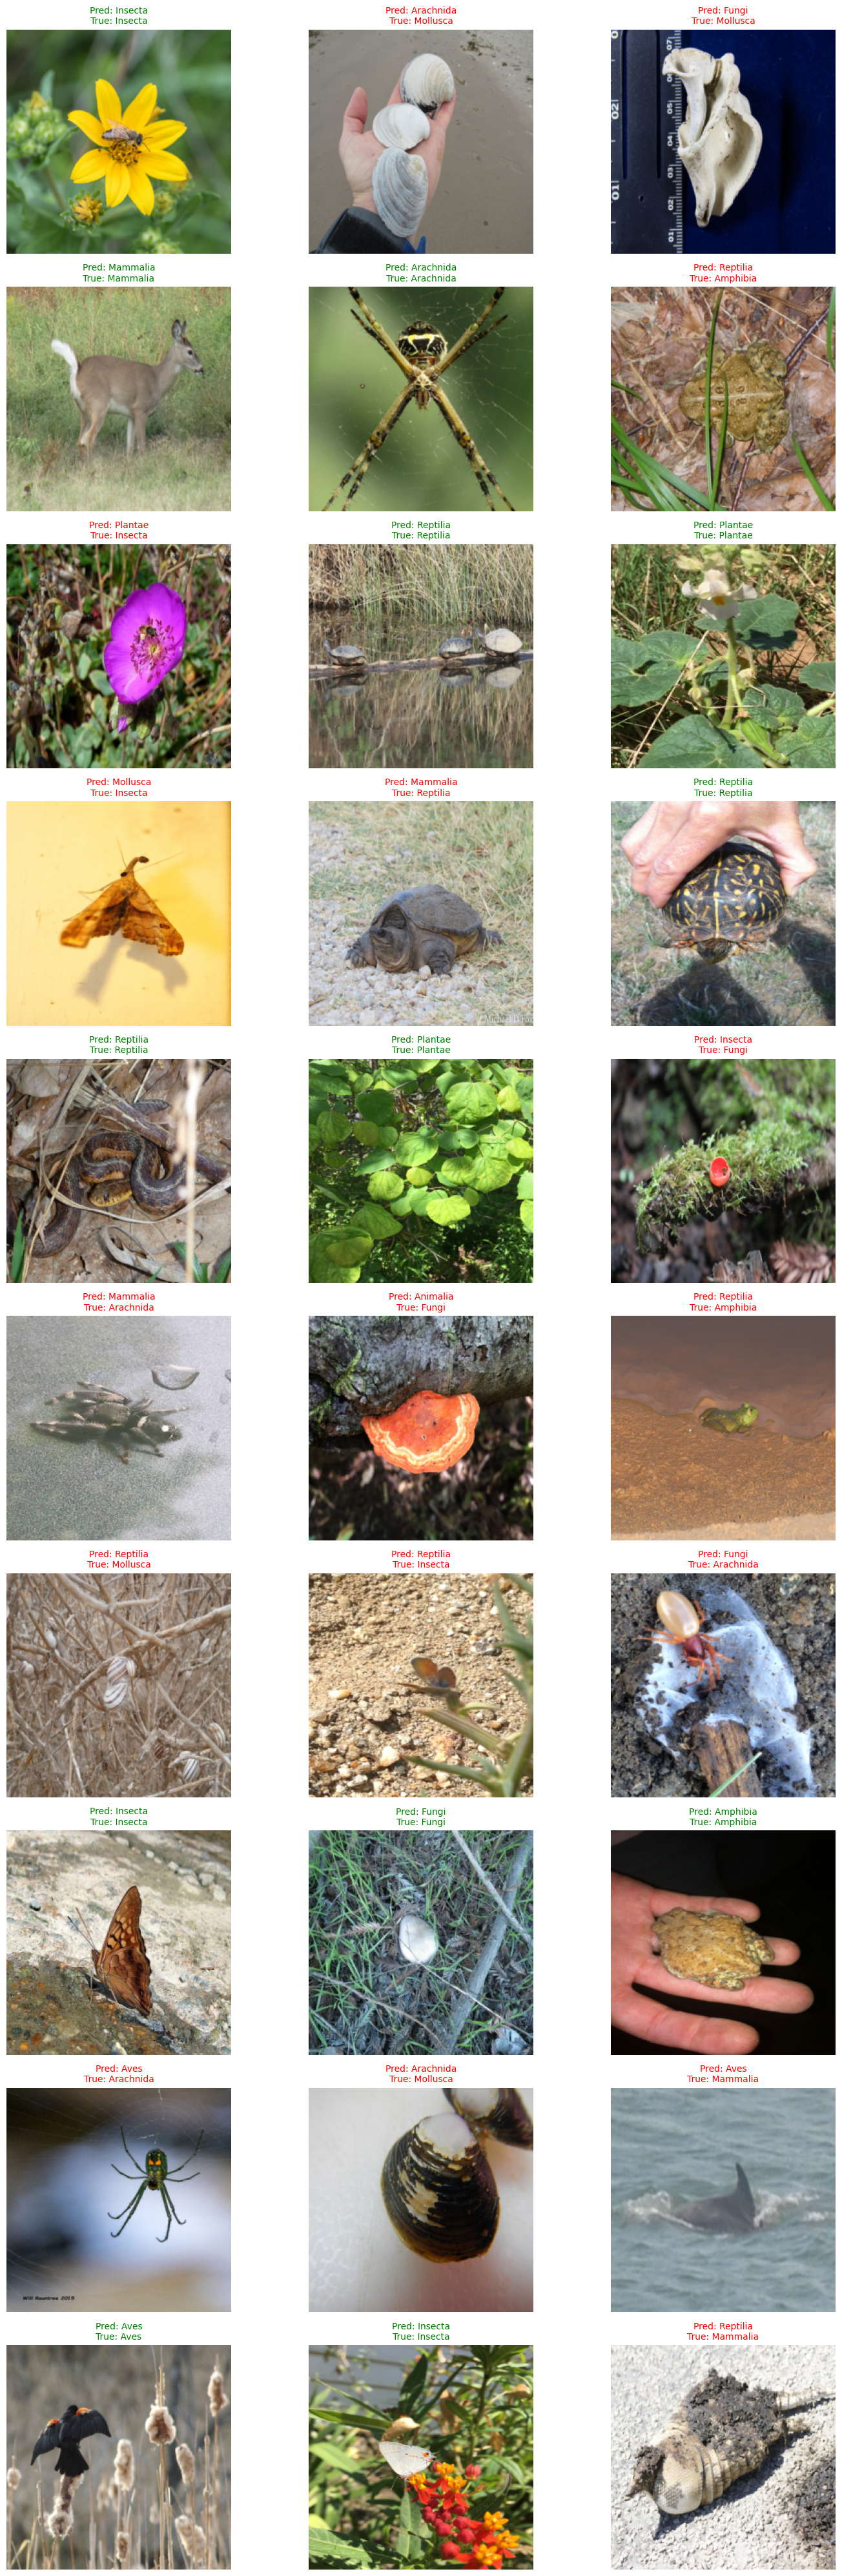

In [4]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_images = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and actual images for visualization
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())
            all_paths.extend(paths)
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels, all_images, all_paths

def visualize_predictions(images, preds, labels, class_names, num_samples=30):
    """Create a 10x3 grid of sample images with predictions"""
    fig = plt.figure(figsize=(15, 40))
    #plt.title("Test Set Predictions with color to indicate correctness", fontsize=16)
    
    for idx in range(num_samples):
        ax = plt.subplot(10, 3, idx + 1)
        
        # Get the original image
        img = images[idx]
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).numpy()
            # Denormalize if necessary
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
        
        plt.imshow(img)
        
        # Set title color based on prediction correctness
        color = 'green' if preds[idx] == labels[idx] else 'red'
        title = f'Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}'
        ax.set_title(title, color=color, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('/kaggle/working/test_predictions_grid.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    wandb.log({"cnn_test_images": wandb.Image(fig)})

def main():

    wandb.init(project="DL_A2")
    wandb.run.name = "test_preds_new"
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Define the same transforms as used during training
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load test dataset
    test_dataset = iNaturalistDataset("/kaggle/input/inaturalist12k/inaturalist_12K/val", transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    # Initialize model with your best configuration
    model = FlexibleCNN(
        num_classes=10,
        conv_filters=[512,256,128,64,32],  # Your best configuration
        activation='silu',  # Your best configuration
        dense_neurons=64,  # Your best configuration
        dropout_rate=0,  # Your best configuration
        use_batch_norm=True  # Your best configuration
    ).to(device)
    
    # Load the best model weights
    model.load_state_dict(torch.load('/kaggle/input/best_cnn/pytorch/default/1/best_model.pth'))
    
    # Evaluate the model
    accuracy, predictions, true_labels, test_images, image_paths = evaluate_model(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    wandb.log({"test_acc": accuracy})
    # Create visualization grid
    class_names = test_dataset.classes
    visualize_predictions(test_images, predictions, true_labels, class_names)
    #print("Visualization grid has been saved as 'test_predictions_grid.png'")

if __name__ == "__main__":
    main()

## Part B

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import wandb
from tqdm import tqdm


def setup_model(num_classes = 10, strategy='last_layer'):
    """
    Set up VGG19 model with different fine-tuning strategies
    
    Args:
        num_classes (int): Number of classes in the target dataset
        strategy (str): Fine-tuning strategy ('last_layer', 'partial', or 'full')
    """
    # Load pre-trained VGG19
    model = models.vgg19(pretrained=True)
    
    # Modify the classifier for our number of classes
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    # Apply different fine-tuning strategies
    if strategy == 'last_layer':
        # Freeze all layers except the last one
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True
            
    elif strategy == 'partial':
        # Freeze early layers, unfreeze later layers
        # Here we're unfreezing the last few convolutional blocks and classifier
        layers_to_unfreeze = list(model.features)[-8:] + list(model.classifier)
        for param in model.parameters():
            param.requires_grad = False
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True
                
    # For 'full' strategy, all parameters are trainable by default
    
    return model

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Set up data transforms
        # Note: VGG19 expects 224x224 input images
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # VGG19 expected input size
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Load dataset
        dataset = iNaturalistDataset("/kaggle/input/inaturalist12k/inaturalist_12K/train", transform=train_transform)
        
        # Split into train and validation
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # Apply validation transform
        val_dataset.dataset.transform = val_transform
        
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
        
        # Setup model with specified fine-tuning strategy
        model = setup_model(num_classes=10, strategy=config.fine_tune_strategy)
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Using device: {device}")
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        
        # Use different learning rates for fine-tuned layers vs new layers
        if config.fine_tune_strategy == 'last_layer':
            optimizer = optim.Adam(model.classifier[6].parameters(), lr=config.learning_rate)
        else:
            # Use different learning rates for pre-trained and new layers
            classifier_params = list(model.classifier[6].parameters())
            other_params = [p for name, p in model.named_parameters() 
                          if p.requires_grad and not any(p is x for x in classifier_params)]
            
            optimizer = optim.Adam([
                {'params': other_params, 'lr': config.learning_rate * 0.1},
                {'params': classifier_params, 'lr': config.learning_rate}
            ])
        
        # Training loop
        best_val_acc = 0.0
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels, _ in tqdm(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            # Calculate metrics
            train_acc = 100. * train_correct / train_total
            val_acc = 100. * val_correct / val_total
            
            print(f"Epoch [{epoch+1}/{config.epochs}], "
                  f"Train Loss: {train_loss/len(train_loader):.4f}, "
                  f"Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss/len(val_loader):.4f}, "
                  f"Val Acc: {val_acc:.2f}%")
            
            # Log metrics
            wandb.log({
                'train_loss': train_loss/len(train_loader),
                'train_acc': train_acc,
                'val_loss': val_loss/len(val_loader),
                'val_acc': val_acc,
                'epoch': epoch
            })

            config = wandb.config
            
            run_name = "lr_{}_bs_{}_st_{}".format(
                config.learning_rate, config.batch_size, config.fine_tune_strategy
            )

            wandb.run.name = run_name
            wandb.run.save()
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), '/kaggle/working/best_vgg19_model.pth')

if __name__ == '__main__':
    # Define sweep configuration
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'batch_size': {'values': [16, 32, 64]},
            'learning_rate': {'values': [0.001, 0.0001, 0.01]},
            'epochs': {'value': 10},
            'fine_tune_strategy': {'values': ['last_layer']}
        }
    }
    
    # Initialize sweep
    sweep_id = wandb.sweep(sweep_config, project="DL_A2")
    wandb.agent(sweep_id, function=train_model)